<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb"><< 212 - AC SAF - GOME-2 - Level 2 - Preprocess</a><span style="float:right;"><a href="./214_ltpy_AC_SAF_GOME-2_L3.ipynb">214 - AC SAF GOME-2 - Level 3 data >></a></span>

# 2.1.3 AC SAF GOME-2 - Produce monthly GOME-2 Level 3 (gridded) climate products

This modules provides an example how a monthly gridded (Level 3) climate record from GOME-2 Level 2 data can be produced.
The full workflow is described in details on page 19 in the [Algorithm Theoretical Basis Document & Product User Manual for GOME-2 NO2 and H2O Level 3 Climate Products](https://acsaf.org/docs/atbd/Algorithm_Theoretical_Basis_Document_Product_User_Manual_NO2_H2O_TCDR_Nov_2017.pdf)

The example produces a gridded data record for January 2020 for the atmospheric parameter `Nitrogen Dioxide (NO2)`.

#### This module has the following outline:
- [Load Metop-A and Metop-B GOME-2 Level 2 data files for one month](#load)
- [Mask and flag low-quality pixels](#mask)
- [Binning of L2 data onto a defined two-dimensional grid](#binning)
- [Visualize the gridded Level 3 NO2 climate record for January 2020](#visualize)

#### Load required libraries

In [3]:
%matplotlib inline
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np


# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

import warnings
warnings.simplefilter(action = "ignore", category = AttributeError)


#### Load functions

In [4]:
from ipynb.fs.full.ltpy_functions import load_l2_data_xr, visualize_s5p_pcolormesh, generate_masked_array


<hr>

## <a id='load'></a>Load Metop-A and Metop-B GOME-2 Level 2 data files for one month

### Load total column NO2, cloud fraction and index scan values for January 2020 from Metop-A

#### Load NO2 data values for one day in January 2020 into a xarray DataArray

The GOME-2 Level 2 data have been downloaded from DLR's ftp server. On the server, the data is organised by satellite (Metop-A and Metop-B) followed by a year, month and day folder structure. 

The data files for January 2020 are under `./eodata/gome2/offline/2a/2020/01/` and `./eodata/gome2/offline/2b/2020/01/`. Both folders contain subfolders for each day. The aim is to load all NO2 data values of one month into one xarray `DataArray` object. 

To do this, we create first a list of all the folders within the folder for January 2020 and call it `folder_list`. Next, we load the NO2 data files for one day in January 2020 into a xarray `DataArray` object. We use the [load_l2_data_xr](./ltpy_functions.ipynb#load_l2_data_xr) function to do this.

The loaded DataArray object with tropospheric NO2 values contains 211329 ground pixel values>


In [1]:
directory_2a= './eodata/gome2/offline/2a/2020/01/'

In [5]:
folder_list = os.listdir(directory_2a)
folder_list

['18',
 '31',
 '13',
 '06',
 '23',
 '08',
 '07',
 '25',
 '03',
 '27',
 '17',
 '05',
 '16',
 '15',
 '20',
 '10',
 '02',
 '22',
 '09',
 '30',
 '29',
 '04',
 '24',
 '26',
 '28',
 '01',
 '11',
 '12',
 '21',
 '14',
 '19']

In [6]:
folder_list = os.listdir(directory_2a)
data_array_a = load_l2_data_xr(os.path.join(directory_2a, folder_list[0]), 'hdf5', 'TOTAL_COLUMNS', 'NO2Tropo', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='NO2Tropo', unit='mol/cm\u00b2',longname='Tropospheric column density of NO2')
data_array_a


<xarray.DataArray 'NO2Tropo' (ground_pixel: 211229)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.321625 65.00611 ... -67.691246
    longitude  (ground_pixel) float32 43.39742 42.984444 ... 273.77722 273.5034
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

#### Load quality flag information (cloud fraction and index scan) as xarray DataArray objects



The [Product User Manual for GOME-2 NO2 and H2O Level 3 Climate Products](https://acsaf.org/docs/atbd/Algorithm_Theoretical_Basis_Document_Product_User_Manual_NO2_H2O_TCDR_Nov_2017.pdf) explains in detail the procedure how Level 3 climate products for NO2 and H2O are produced. Low quality measurements are flagged out in three ways:
- negative values
- pixels with a cloud fraction higher than 20%, and
- backward scan pixels

Cloud property and index scan information are part of each data file. Thus, additionally to the data values, we load the `cloud_fraction` as well as the `index_scan` information for one day in January 2020. Cloud fraction information are under the group path `ClOUD_PROPERTIES/CloudFraction` in the data file and index scan information are under `GEOLOCATION/IndexInScan`.

Both information can be loaded by using the [load_l2_data_xr](./ltpy_functions.ipynb#load_l2_data_xr) function.


In [7]:
cloud_fraction_a = load_l2_data_xr(os.path.join(directory_2a, folder_list[0]), 'hdf5', 'CLOUD_PROPERTIES', 'CloudFraction', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='cloud_fraction', unit='-', longname='Cloud Fraction')

index_scan_a = load_l2_data_xr(os.path.join(directory_2a, folder_list[0]), 'hdf5', 'GEOLOCATION', 'IndexInScan', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='indexflag', unit='-', longname='Index in Scan')


#### Loop through all days of January 2020 and load NO2, cloud fraction and index scan values from Metop-A into one DataArray object

Once we built three data arrays, NO2 data values, cloud fraction information and index scan information, for one day, we can loop through the remaining days of the month and concatenate the additional information to each data array. For concatenating two data arrays, we can use xarray's function `concat`.

We loop through the defined `folder_list` and skip the first entry. For each of the three data arrays, we first load all data files of the respective day into a xarray `DataArray` object (with the help of the [load_l2_data_xr](./ltpy_fuctions.ipynb#load_l2_data_xr) function and concatenate it to the existing `DataArray` objects, `data_array_a`, `cloud_fraction_a` and `index_scan_a` respectively.

In [8]:
for folder in folder_list[1:]:
    folder_path = os.path.join(directory_2a,folder)
    print(folder_path)
    data_array = load_l2_data_xr(folder_path, 'hdf5', 'TOTAL_COLUMNS', 'NO2Tropo', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='NO2Tropo', unit='mol/cm\u00b2',longname='Tropospheric column density of NO2')
    data_array_a = xr.concat([data_array_a, data_array], dim='ground_pixel')

    cloud_fraction = load_l2_data_xr(folder_path, 'hdf5', 'CLOUD_PROPERTIES', 'CloudFraction', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='cloud_fraction', unit='-', longname='Cloud Fraction')
    cloud_fraction_a = xr.concat([cloud_fraction_a, cloud_fraction], dim='ground_pixel')

    index_scan = load_l2_data_xr(folder_path, 'hdf5', 'GEOLOCATION', 'IndexInScan', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='indexflag', unit='-', longname='Index in Scan')
    index_scan_a = xr.concat([index_scan_a, index_scan], dim='ground_pixel')
    
    

./eodata/gome2/offline/2a/2020/01/31
./eodata/gome2/offline/2a/2020/01/13
./eodata/gome2/offline/2a/2020/01/06
./eodata/gome2/offline/2a/2020/01/23
./eodata/gome2/offline/2a/2020/01/08
./eodata/gome2/offline/2a/2020/01/07
./eodata/gome2/offline/2a/2020/01/25
./eodata/gome2/offline/2a/2020/01/03
./eodata/gome2/offline/2a/2020/01/27
./eodata/gome2/offline/2a/2020/01/17
./eodata/gome2/offline/2a/2020/01/05
./eodata/gome2/offline/2a/2020/01/16
./eodata/gome2/offline/2a/2020/01/15
./eodata/gome2/offline/2a/2020/01/20
./eodata/gome2/offline/2a/2020/01/10
./eodata/gome2/offline/2a/2020/01/02
./eodata/gome2/offline/2a/2020/01/22
./eodata/gome2/offline/2a/2020/01/09
./eodata/gome2/offline/2a/2020/01/30
./eodata/gome2/offline/2a/2020/01/29
./eodata/gome2/offline/2a/2020/01/04
./eodata/gome2/offline/2a/2020/01/24
./eodata/gome2/offline/2a/2020/01/26
./eodata/gome2/offline/2a/2020/01/28
./eodata/gome2/offline/2a/2020/01/01
./eodata/gome2/offline/2a/2020/01/11
./eodata/gome2/offline/2a/2020/01/12
.

The three data arrays `data_array_a`, `cloud_fraction_a` and `index_scan_a` have the same number of ground pixels. 

In [9]:
data_array_a, cloud_fraction_a, index_scan_a

(<xarray.DataArray 'NO2Tropo' (ground_pixel: 6625455)>
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
 Coordinates:
     latitude   (ground_pixel) float32 65.321625 65.00611 ... -68.291824
     longitude  (ground_pixel) float32 43.39742 42.984444 ... 178.14725 177.86438
 Dimensions without coordinates: ground_pixel
 Attributes:
     long_name:  Tropospheric column density of NO2
     units:      mol/cm²,
 <xarray.DataArray 'cloud_fraction' (ground_pixel: 6625455)>
 array([0.6067938, 0.6265617, 0.648112 , ..., 1.       , 1.       ,
        1.       ], dtype=float32)
 Coordinates:
     latitude   (ground_pixel) float32 65.321625 65.00611 ... -68.291824
     longitude  (ground_pixel) float32 43.39742 42.984444 ... 178.14725 177.86438
 Dimensions without coordinates: ground_pixel
 Attributes:
     long_name:  Cloud Fraction
     units:      -,
 <xarray.DataArray 'indexflag' (ground_pixel: 6625455)>
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
 Coordinates:
     latitude   (grou

### Load total column NO2, cloud fraction and index scan values for January 2020 from Metop-B

Now we can repeat the steps above for the data files for January 2020 from Metop-B.

#### Load NO2, cloud fraction and index scan values for one day in January 2020 from the Metop-B satellite

In [10]:
directory_2b= './eodata/gome2/offline/2b/2020/01/'
folder_list = os.listdir(directory_2b)
data_array_b = load_l2_data_xr(os.path.join(directory_2b, folder_list[0]), 'hdf5', 'TOTAL_COLUMNS', 'NO2Tropo', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='NO2Tropo', unit='mol/cm\u00b2',longname='Tropospheric column density of NO2')

cloud_fraction_b = load_l2_data_xr(os.path.join(directory_2b, folder_list[0]), 'hdf5', 'CLOUD_PROPERTIES', 'CloudFraction', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='cloud_fraction', unit='-', longname='Cloud Fraction')

index_scan_b = load_l2_data_xr(os.path.join(directory_2b, folder_list[0]), 'hdf5', 'GEOLOCATION', 'IndexInScan', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='indexflag', unit='-', longname='Index in Scan')


#### Loop through all days of January 2020 and load NO2, cloud fraction and index scan values from Metop-B into one DataArray object

In [11]:
for folder in folder_list[1:]:
    folder_path = os.path.join(directory_2b,folder)
    print(folder_path)
    data_array = load_l2_data_xr(folder_path, 'hdf5', 'TOTAL_COLUMNS', 'NO2Tropo', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='NO2Tropo', unit='mol/cm\u00b2',longname='Tropospheric column density of NO2')
    data_array_b = xr.concat([data_array_b, data_array], dim='ground_pixel')
    
    cloud_fraction = load_l2_data_xr(folder_path, 'hdf5', 'CLOUD_PROPERTIES', 'CloudFraction', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='cloud_fraction', unit='-', longname='Cloud Fraction')
    cloud_fraction_b = xr.concat([cloud_fraction_b, cloud_fraction], dim='ground_pixel')

    index_scan = load_l2_data_xr(folder_path, 'hdf5', 'GEOLOCATION', 'IndexInScan', 'GEOLOCATION/LatitudeCentre', 'GEOLOCATION/LongitudeCentre', 1, paramname='indexflag', unit='-', longname='Index in Scan')
    index_scan_b = xr.concat([index_scan_b, index_scan], dim='ground_pixel')

./eodata/gome2/offline/2b/2020/01/06
./eodata/gome2/offline/2b/2020/01/10
./eodata/gome2/offline/2b/2020/01/14
./eodata/gome2/offline/2b/2020/01/18
./eodata/gome2/offline/2b/2020/01/22
./eodata/gome2/offline/2b/2020/01/26
./eodata/gome2/offline/2b/2020/01/30
./eodata/gome2/offline/2b/2020/01/03
./eodata/gome2/offline/2b/2020/01/07
./eodata/gome2/offline/2b/2020/01/11
./eodata/gome2/offline/2b/2020/01/15
./eodata/gome2/offline/2b/2020/01/19
./eodata/gome2/offline/2b/2020/01/23
./eodata/gome2/offline/2b/2020/01/27
./eodata/gome2/offline/2b/2020/01/31
./eodata/gome2/offline/2b/2020/01/04
./eodata/gome2/offline/2b/2020/01/08
./eodata/gome2/offline/2b/2020/01/12
./eodata/gome2/offline/2b/2020/01/16
./eodata/gome2/offline/2b/2020/01/20
./eodata/gome2/offline/2b/2020/01/24
./eodata/gome2/offline/2b/2020/01/28
./eodata/gome2/offline/2b/2020/01/01
./eodata/gome2/offline/2b/2020/01/05
./eodata/gome2/offline/2b/2020/01/09
./eodata/gome2/offline/2b/2020/01/13
./eodata/gome2/offline/2b/2020/01/17
.

### Concatenate the data arrays from the two satellites Metop-A and Metop-B

You can concatenate two data arrays with xarray's function `xr.concat()`. We want to use `ground_pixel` as the dimension data values get concatenated. We concatenate the data arrays for three variables, `NO2 data array`, `cloud fraction` and `index scan`.

In [12]:
data_ab = xr.concat([data_array_a, data_array_b], dim='ground_pixel')

cloud_fraction_ab = xr.concat([cloud_fraction_a, cloud_fraction_b], dim='ground_pixel')

index_scan_ab = xr.concat([index_scan_a, index_scan_b], dim='ground_pixel')

The three data arrays have the same amount of ground pixels (13219163).

In [13]:
data_ab, cloud_fraction_ab, index_scan_ab

(<xarray.DataArray 'NO2Tropo' (ground_pixel: 13219163)>
 array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
 Coordinates:
     latitude   (ground_pixel) float32 65.321625 65.00611 ... -73.4391 -73.09682
     longitude  (ground_pixel) float32 43.39742 42.984444 ... 323.1829 322.9331
 Dimensions without coordinates: ground_pixel
 Attributes:
     long_name:  Tropospheric column density of NO2
     units:      mol/cm²,
 <xarray.DataArray 'cloud_fraction' (ground_pixel: 13219163)>
 array([0.6067938 , 0.6265617 , 0.648112  , ..., 0.94127154, 0.94490767,
        0.9001974 ], dtype=float32)
 Coordinates:
     latitude   (ground_pixel) float32 65.321625 65.00611 ... -73.4391 -73.09682
     longitude  (ground_pixel) float32 43.39742 42.984444 ... 323.1829 322.9331
 Dimensions without coordinates: ground_pixel
 Attributes:
     long_name:  Cloud Fraction
     units:      -,
 <xarray.DataArray 'indexflag' (ground_pixel: 13219163)>
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
 Coordinates:


## <a id='mask'></a>Mask and flag low-quality pixels

Low quality measurements are flagged out in three ways:
- negative values
- pixels with a cloud fraction higher than 20%, and
- backward scan pixels

#### Flag negative values from the NO2 data array

Negative values can be flagged out with xarray's function `xr.where`. We cast only positive values and if value is negative, it is replaced with `NaN`.

In [14]:
data_ab_flagged = xr.where(data_ab > 0, data_ab, np.nan)
data_ab_flagged

<xarray.DataArray 'NO2Tropo' (ground_pixel: 13219163)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.321625 65.00611 ... -73.4391 -73.09682
    longitude  (ground_pixel) float32 43.39742 42.984444 ... 323.1829 322.9331
Dimensions without coordinates: ground_pixel

#### Mask backward scan pixels

The `IndexInScan` information is an integer value from 0 to 3, with the following descrition:
- 0-2 forward scan (0-east part of scan, 1-centre part of scan, 2-west part of scan)
- 3 backward scan
Thus, we want to mask out all pixels which have a index scan flag of three and want to keep the pixels with index scan flag 0, 1 and 2.

You can find more information on all the metadata of the GOME-2 Level 2 Trace Gas data in the [Product User Manual](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf).

For masking, we can use the function [generate_masked_array](./ltpy_functions.ipynb#generate_masked_array). We set the drop keyword argument to `False` to ensure the same amount of ground pixels during the masking process.

In [15]:
no2_ab_masked_is = generate_masked_array(data_ab_flagged, index_scan_ab, 3 , '!=', drop=False)
no2_ab_masked_is



<xarray.DataArray (ground_pixel: 13219163)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.321625 65.00611 ... -73.4391 -73.09682
    longitude  (ground_pixel) float32 43.39742 42.984444 ... 323.1829 322.9331
Dimensions without coordinates: ground_pixel


<xarray.DataArray (ground_pixel: 13219163)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.321625 65.00611 ... -73.4391 -73.09682
    longitude  (ground_pixel) float32 43.39742 42.984444 ... 323.1829 322.9331
Dimensions without coordinates: ground_pixel

#### Mask cloud fraction information

We only want to keep pixels with a cloud fraction less than 20%. To mask it, we can use again the [generate_masked_array](./ltpy_functions.ipynb#generate_masked_array) function and set the masking conditions to `less than` 0.2. We now set the drop keywork argument to `True`, as this is our last masking step and there is no benefit in keeping the non-valid pixels.

In [16]:
no2_ab_masked_is_cf = generate_masked_array(no2_ab_masked_is, cloud_fraction_ab, 0.2 , '<', drop=True)
no2_ab_masked_is_cf


<xarray.DataArray (ground_pixel: 13219163)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.321625 65.00611 ... -73.4391 -73.09682
    longitude  (ground_pixel) float32 43.39742 42.984444 ... 323.1829 322.9331
Dimensions without coordinates: ground_pixel


<xarray.DataArray (ground_pixel: 896126)>
array([1.5838249e+15, 2.5731197e+15, 1.8151346e+15, ..., 2.5440739e+14,
       8.4159555e+14, 3.0547747e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 50.588924 47.899586 ... -65.21503
    longitude  (ground_pixel) float32 25.91935 24.229082 ... 124.395515
Dimensions without coordinates: ground_pixel

## <a id='binning'></a>Binning of L2 data onto a defined two-dimensional grid

The longitude values of the AC SAF GOME-2 Level 2 data are stored as 0 to 360 degrees longitudes. In order to visualize the data on a -180 to 180 degrees grid, we have to convert the longitude values first. We can use the `assign_coords` function of the xarray library to re-assign the longitude values.

In [17]:
no2_ab_masked = no2_ab_masked_is_cf.assign_coords(longitude=(((no2_ab_masked_is_cf.longitude + 180) % 360) - 180))
no2_ab_masked

<xarray.DataArray (ground_pixel: 896126)>
array([1.5838249e+15, 2.5731197e+15, 1.8151346e+15, ..., 2.5440739e+14,
       8.4159555e+14, 3.0547747e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 50.588924 47.899586 ... -65.21503
    longitude  (ground_pixel) float32 25.919342 24.22908 ... 122.46246 124.39551
Dimensions without coordinates: ground_pixel

### Retrieve data values and latitude and longitude data information

For the binning process, we need the latitude and longitudde information. We can retrieve the data from our masked data object.

In [22]:
y = no2_ab_masked.latitude.data
x = no2_ab_masked.longitude.data

len(x), len(y)

(896126, 896126)

And we also want to retrieve the NO2 data values and call the new variable `z`.

In [21]:
z = no2_ab_masked.data
len(z)

896126

### Bin the data onto a 2D-grid with `np.histogram2d`

With `np.histogram2d`, we can bin the data onto a pre-defined 2-dimensional grid (called bins). By assigning our data value object `z` to the keyword argument `weights`, the bin gets assigned the data value of the point that falls into the cell.

Since there will be more data points assigned to one cell (bin), we also create a `counts` array, which sums up the number of data points fallen into a bin.

The example below builds a regular grid of 1 deg x 1 deg. NO2 climate records can be binned onto a grid up to 0.25 deg x 0.25 deg. If you wish to make the grid with a finer resolution, you can set the bins to `bins=(720,1440)`.

In [20]:
zi, yi, xi = np.histogram2d(y, x, bins=(180,360), weights=z, normed=False)
counts, _, _ = np.histogram2d(y, x, bins=(180,360))


### Build the `arithmetic mean` of all the data points fallen into a bin

The `counts` array can be used to build the`arithmetic mean` of all the data points fallen into one bin.

In [26]:
zi = zi / counts
zi

array([[6.65300547e+14, 3.48625521e+14, 7.07477801e+14, ...,
        3.97193998e+14, 4.15949380e+14, 5.49651634e+14],
       [4.11706880e+14, 4.44407858e+14, 4.48569863e+14, ...,
        1.69415853e+14, 3.31109276e+14, 5.93984432e+14],
       [7.11339362e+13, 2.16676268e+14, 4.18386594e+14, ...,
        3.30476421e+14, 7.14098208e+14, 6.70187006e+14],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

## <a id='visualize'></a>Visualize the gridded Level 3 NO2 climate record for January 2020

The final step is to visualize the gridded data array, together with the latitude and longitude information. We can use the function `visualize_s5p_pcolormesh` to plot the data with matplotlib's plotting function `pcolormesh`.

We multiple the NO2 values with `1e-15` to facilitate the plotting.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f493c011438>)

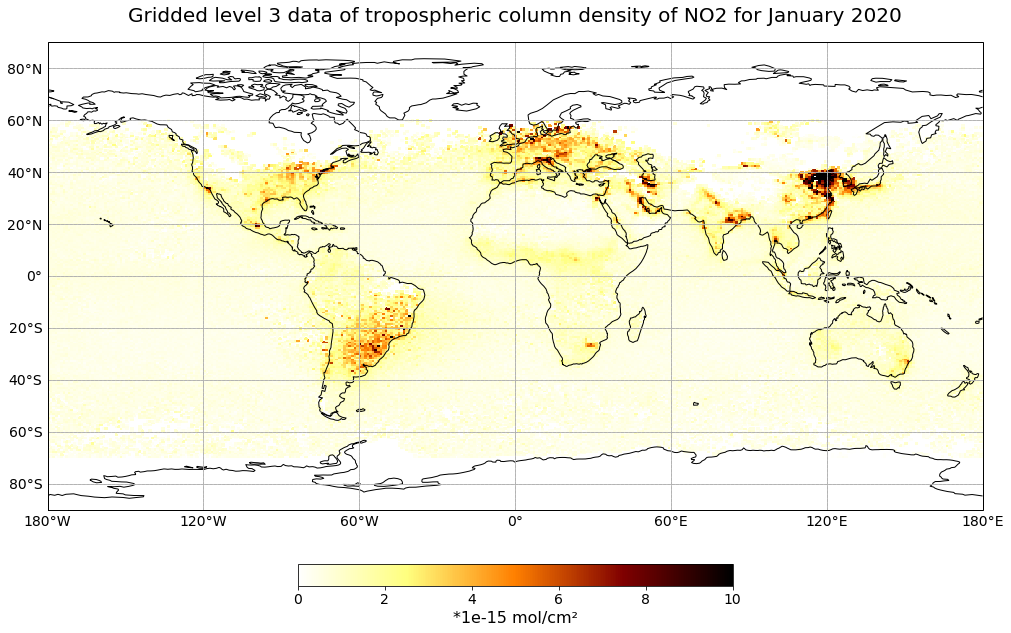

In [27]:
visualize_s5p_pcolormesh(zi*1e-15, xi, yi, ccrs.PlateCarree(), 
                         'afmhot_r', 
                         '*1e-15 mol/cm\u00b2', 
                         'Gridded level 3 data of tropospheric column density of NO2 for January 2020', 
                         0, 10, 
                         -180, 180, -90, 90, 
                         log=False, 
                         set_global=True)




<br>

<a href="./212_ltpy_AC_SAF_GOME-2_L2_preprocess.ipynb"><< 212 - AC SAF - GOME-2 - Level 2 - Preprocess</a><span style="float:right;"><a href="./214_ltpy_AC_SAF_GOME-2_L3.ipynb">214 - AC SAF GOME-2 - Level 3 data >></a></span>

<hr>

<p><img src='./img/copernicius_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>